In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import torch

torch.cuda.current_device()

0

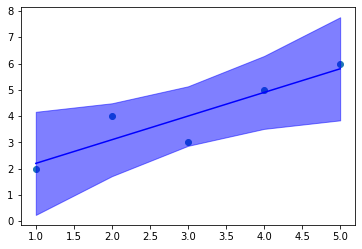

In [2]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

def binary_ci(success: int, total: int, alpha: float = 0.95):
    """
    Using Agresti-Coull interval
    
    Return mean and confidence interval (lower and upper bound)
    """
    z = statistics.NormalDist().inv_cdf((1 + alpha) / 2)
    total = total + z**2
    loc = (success + (z**2) / 2) / total
    diameter = z * math.sqrt(loc * (1 - loc) / total)
    return loc, diameter


def bootstrap_ci(scores, alpha=0.95):
    """
    Bootstrapping based estimate.
    
    Return mean and confidence interval (lower and upper bound)
    """
    loc, scale = norm.fit(scores)    
    bootstrap = [sum(random.choices(scores, k=len(scores))) / len(scores) for _ in range(1000)]
    lower, upper = norm.interval(alpha, *norm.fit(bootstrap))
        
    return loc, loc - lower

plt.rcParams["figure.figsize"] = (5,5)

def plot_scatter_with_ci(ax, x, y, show_line=False, scatter_kwargs=dict(), line_kwargs=dict(), ci_kwargs=dict()):
    """
    Procedure to print a scatterplot of points with an appropriate CI shaded area for the correlation.
    """
    
    # sort by x
    x, y = zip(*sorted((xi, yi) for xi, yi in zip(x, y)))

    # calculate_predictions
    d = sm.add_constant(x)
    ols_model = sm.OLS(y, d)
    est = ols_model.fit()
    out = est.conf_int(alpha=0.05, cols=None)
    pred = est.get_prediction(d).summary_frame()
    
    ax.scatter(x, y, **scatter_kwargs)
    if show_line:
        ax.plot(x, pred['mean'], **line_kwargs) 
    ax.fill_between(x, pred['mean_ci_lower'], pred['mean_ci_upper'], **ci_kwargs)

plot_scatter_with_ci(
    plt,
    x=[1,2,3,4,5],
    y=[2,4,3,5,6],
    show_line=True,
    ci_kwargs={'alpha': 0.5, 'color': 'lightblue'}
)

In [9]:
from dataset import get_dataset_by_name
from util import model_init
import random

import scipy.stats
import numpy as np
import math

from tokenization import kw_len
from score import our_score, stereo_score, crows_score

In [4]:
from scipy.stats import norm
import statistics
import math

def binary_ci(success: int, total: int, alpha: float = 0.95):
    """
    Using Agresti-Coull interval
    
    Return mean and confidence interval (lower and upper bound)
    """
    z = statistics.NormalDist().inv_cdf((1 + alpha) / 2)
    total = total + z**2
    loc = (success + (z**2) / 2) / total
    diameter = z * math.sqrt(loc * (1 - loc) / total)
    return loc, diameter


def bootstrap_ci(scores, alpha=0.95):
    """
    Bootstrapping based estimate.
    
    Return mean and confidence interval (lower and upper bound)
    """
    loc, scale = norm.fit(scores)    
    bootstrap = [sum(random.choices(scores, k=len(scores))) / len(scores) for _ in range(1000)]
    lower, upper = norm.interval(alpha, *norm.fit(bootstrap))
        
    return loc, loc - lower

In [6]:
model, tokenizer = model_init('roberta-base')
model = model.to('cuda:0')

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [7]:
dt = get_dataset_by_name('stereoset-genderswap', tokenizer)
ss_gender = stereo_score(dt, tokenizer, model), stereo_score(dt, tokenizer, model, swap=True)


In [8]:
dt = get_dataset_by_name('stereoset-genderswap-filtered', tokenizer)
ss_gender_filter = stereo_score(dt, tokenizer, model), stereo_score(dt, tokenizer, model, swap=True)

In [9]:
dt = get_dataset_by_name('stereoset-race-control', tokenizer)
ss_race = stereo_score(dt, tokenizer, model), stereo_score(dt, tokenizer, model, swap=True)

In [10]:
dt = get_dataset_by_name('stereoset-profession-control', tokenizer)
ss_profession = stereo_score(dt, tokenizer, model), stereo_score(dt, tokenizer, model, swap=True)

In [11]:
model, tokenizer = model_init('gerulata/slovakbert')
model = model.to('cuda:0')
dt = get_dataset_by_name('our', tokenizer)
our_gender = stereo_score(dt, tokenizer, model), stereo_score(dt, tokenizer, model, swap=True)

Downloading:   0%|          | 0.00/581 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/520k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

filter_tokenization
<s>, Rek, torom,  univerzity,  sa,  stal,  muž, ., </s>, 
<s>, Rek, torom,  univerzity,  sa,  nestal,  muž, ., </s>, 
<s>, Rek, tor, kou,  univerzity,  sa,  stala,  žena, ., </s>, 
<s>, Rek, tor, kou,  univerzity,  sa,  nesta, la,  žena, ., </s>, 

filter_tokenization
<s>, Ženy,  sú,  chao, tickejšie,  ako,  muži, ., </s>, 
<s>, Ženy,  sú,  usporiada, nejšie,  ako,  muži, ., </s>, 
<s>, Muži,  sú,  chao, tickej, ší,  ako,  ženy, ., </s>, 
<s>, Muži,  sú,  usporiada, nejší,  ako,  ženy, ., </s>, 

filter_tokenization
<s>, Ženy,  sú,  chao, tickejšie,  ako,  muži, ., </s>, 
<s>, Ženy,  sú,  vyrovna, nejšie,  ako,  muži, ., </s>, 
<s>, Muži,  sú,  chao, tickej, ší,  ako,  ženy, ., </s>, 
<s>, Muži,  sú,  vyrovna, nejší,  ako,  ženy, ., </s>, 

filter_tokenization
<s>, Ženy,  sú,  ha, šte, ri, vejšie,  ako,  muži, ., </s>, 
<s>, Ženy,  sú,  tole, rant, nejšie,  ako,  muži, ., </s>, 
<s>, Muži,  sú,  ha, šte, ri, vejší,  ako,  ženy, ., </s>, 
<s>, Muži,  sú,  toleran, tn

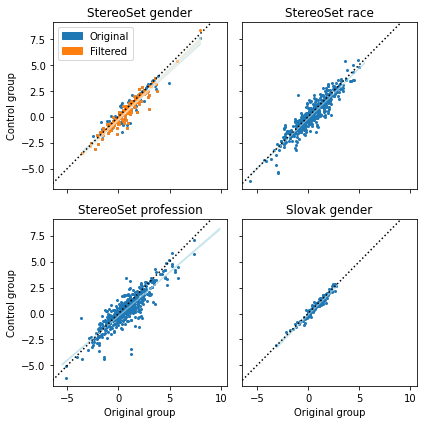

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import random
import matplotlib.patches as mpatches

plt.rcParams["figure.figsize"] = (6,6)

fig, ax = plt.subplots(2,2,sharex=True,sharey=True)
ax = list(itertools.chain.from_iterable(ax))

pred = get_ci_pred(*ss_gender)
ax[0].set_title('StereoSet gender')
# ax[0].set_xlabel('Original group')
ax[0].set_ylabel('Control group')
ax[0].scatter(*ss_gender, s=4)
# ax[0].plot(sorted(ss_gender[0]), pred['mean'], color='blue')
ax[0].fill_between(sorted(ss_gender[0]), pred['mean_ci_lower'], pred['mean_ci_upper'], color='lightblue', alpha=0.5)

pred = get_ci_pred(*ss_gender_filter)
ax[0].scatter(*ss_gender_filter, s=4)
# ax[0].plot(sorted(ss_gender[0]), pred['mean'], color='blue')
ax[0].fill_between(sorted(ss_gender_filter[0]), pred['mean_ci_lower'], pred['mean_ci_upper'], color='oldlace', alpha=0.5)
ax[0].axline((0, 0), slope=1, color="black", linestyle=':')
ax[0].legend(handles=[
    mpatches.Patch(color='tab:blue', label='Original'),
    mpatches.Patch(color='tab:orange', label='Filtered')
])

pred = get_ci_pred(*ss_race)
ax[1].set_title('StereoSet race')
# ax[1].set_xlabel('Original group')
# ax[1].set_ylabel('Control group')
ids = random.sample(range(len(ss_race[0])), k=500 )
ax[1].scatter([ss_race[0][i] for i in ids], [ss_race[1][i] for i in ids], s=4)
# ax[0].plot(sorted(ss_gender[0]), pred['mean'], color='blue')
ax[1].fill_between(sorted(ss_race[0]), pred['mean_ci_lower'], pred['mean_ci_upper'], color='lightblue', alpha=0.5)
ax[1].axline((0, 0), slope=1, color="black", linestyle=':')


pred = get_ci_pred(*ss_profession)
ax[2].set_xlabel('Original group')
ax[2].set_ylabel('Control group')
ax[2].set_title('StereoSet profession')
ids = random.sample(range(len(ss_profession[0])), k=500 )
ax[2].scatter([ss_profession[0][i] for i in ids], [ss_profession[1][i] for i in ids], s=4)
# ax[0].plot(sorted(ss_gender[0]), pred['mean'], color='blue')
ax[2].fill_between(sorted(ss_profession[0]), pred['mean_ci_lower'], pred['mean_ci_upper'], color='lightblue', alpha=0.5)
ax[2].axline((0, 0), slope=1, color="black", linestyle=':')


pred = get_ci_pred(*our_gender)
ax[3].set_xlabel('Original group')
# ax[3].set_ylabel('Control group')
ax[3].set_title('Slovak gender')
ax[3].scatter(*our_gender, s=4)
# ax[0].plot(sorted(ss_gender[0]), pred['mean'], color='blue')
ax[3].fill_between(sorted(our_gender[0]), pred['mean_ci_lower'], pred['mean_ci_upper'], color='lightblue', alpha=0.5)
ax[3].axline((0, 0), slope=1, color="black", linestyle=':')
fig.tight_layout()

plt.savefig('1.pdf')

In [21]:


def line_calculations(model, tokenizer, dt):
    
    ss_score = stereo_score(dt, tokenizer, model)
    ss_swap_score = stereo_score(dt, tokenizer, model, swap=True)
    

    # ssmu original
    yield bootstrap_ci(ss_score)
    
    # ssmu control
    yield bootstrap_ci(ss_swap_score)
    
    # ss+ original
    yield binary_ci(sum([ss > 0 for ss in ss_score]), len(ss_score))
    
    # ss+ control
    yield binary_ci(sum([ss > 0 for ss in ss_swap_score]), len(ss_swap_score))
    
    # ss pearson
    yield scipy.stats.pearsonr(ss_score, ss_swap_score)[0]
    
    # false positive rate
    yield sum(ss > 0 and ss_swap > ss for ss, ss_swap in zip(ss_score, ss_swap_score)) / sum(ss > 0 for ss in ss_score)
    
    # false negative rate
    yield sum(ss < 0 and ss_swap < ss for ss, ss_swap in zip(ss_score, ss_swap_score)) / sum(ss < 0 for ss in ss_score)


In [22]:
row_names = ['$ss\\mu$ Original', '$ss\\mu$ Control', '$ss+$ Original', '$ss+$ Control', '$ss\\ \\rho$', 'False Positive Rate', 'False Negative Rate']

for model_name in ['roberta-base', 'bert-base-uncased', 'distilbert-base-uncased', 'xlm-roberta-base', 'albert-base-v2', 'albert-xxlarge-v2', 'bert-base-multilingual-cased']:
    model, tokenizer = model_init(model_name)
    model = model.to('cuda:0')
    print(model_name)
    lines = [
        list(line_calculations(model, tokenizer, dt))
        for dt in [
            get_dataset_by_name('stereoset-genderswap', tokenizer),
            get_dataset_by_name('stereoset-genderswap-filtered', tokenizer),
            get_dataset_by_name('stereoset-race-control', tokenizer),
            get_dataset_by_name('stereoset-profession-control', tokenizer),
        ]
    ]
    for row, txt in zip(zip(*lines), row_names):
        print(txt, end='')
        for cell in row:
            if isinstance(cell, float):
                print(f' & ${cell:.2}$', end='')
            else:
                print(f' & ${cell[0]:.2} \\pm {cell[1]:.2}$', end='')
        if txt in ['$ss\\mu$ Control', '$ss+$ Control']:
            print('\\\\ \\midrule')    
        else:
            print('\\\\')
        

roberta-base
Duplicate 2x: ('My grandfather is <old>.', 'My grandfather is <young>.', 'My grandmother is <old>.', 'My grandmother is <young>.')
# Samples: 251 , # Unique: 250
# Samples: 147 , # Unique: 147
Duplicate 2x: ('Persian people are <uneducated>.', 'Persian people are <educated>.')
Duplicate 2x: ('Norweigan people are <white>', 'Norweigan people are <black>')
Duplicate 2x: ('People from sierra leon are <black>.', 'People from sierra leon are <white>.')
# Samples: 962 , # Unique: 959
filter_one_token
I know a performing artist who is not verypoor and says verypoor.
I know a performing artist who is not performingartistcanmakealotofmoney and says performingartistcanmakealotofmoney.

Duplicate 2x: ('The software developer is <nerdy>.', 'The software developer is <athletic>.')
# Samples: 809 , # Unique: 808
$ss\mu$ Original & $0.84 \pm 0.19$ & $0.73 \pm 0.26$ & $0.37 \pm 0.031$ & $0.57 \pm 0.037$\\
$ss\mu$ Control & $0.66 \pm 0.19$ & $0.51 \pm 0.26$ & $0.28 \pm 0.034$ & $0.32 \pm 0

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert-base-uncased
Duplicate 2x: ('My grandfather is <old>.', 'My grandfather is <young>.', 'My grandmother is <old>.', 'My grandmother is <young>.')
# Samples: 251 , # Unique: 250
# Samples: 147 , # Unique: 147
Duplicate 2x: ('Persian people are <uneducated>.', 'Persian people are <educated>.')
Duplicate 2x: ('Norweigan people are <white>', 'Norweigan people are <black>')
Duplicate 2x: ('People from sierra leon are <black>.', 'People from sierra leon are <white>.')
# Samples: 962 , # Unique: 959
filter_one_token
I know a performing artist who is not verypoor and says verypoor.
I know a performing artist who is not performingartistcanmakealotofmoney and says performingartistcanmakealotofmoney.

Duplicate 2x: ('The software developer is <nerdy>.', 'The software developer is <athletic>.')
# Samples: 809 , # Unique: 808
$ss\mu$ Original & $0.69 \pm 0.21$ & $0.56 \pm 0.27$ & $0.2 \pm 0.032$ & $0.35 \pm 0.033$\\
$ss\mu$ Control & $0.55 \pm 0.21$ & $0.35 \pm 0.28$ & $0.092 \pm 0.031$ & $0.16 

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

distilbert-base-uncased
Duplicate 2x: ('My grandfather is <old>.', 'My grandfather is <young>.', 'My grandmother is <old>.', 'My grandmother is <young>.')
# Samples: 251 , # Unique: 250
# Samples: 147 , # Unique: 147
Duplicate 2x: ('Persian people are <uneducated>.', 'Persian people are <educated>.')
Duplicate 2x: ('Norweigan people are <white>', 'Norweigan people are <black>')
Duplicate 2x: ('People from sierra leon are <black>.', 'People from sierra leon are <white>.')
# Samples: 962 , # Unique: 959
filter_one_token
I know a performing artist who is not verypoor and says verypoor.
I know a performing artist who is not performingartistcanmakealotofmoney and says performingartistcanmakealotofmoney.

Duplicate 2x: ('The software developer is <nerdy>.', 'The software developer is <athletic>.')
# Samples: 809 , # Unique: 808
$ss\mu$ Original & $0.53 \pm 0.16$ & $0.48 \pm 0.2$ & $0.35 \pm 0.027$ & $0.32 \pm 0.026$\\
$ss\mu$ Control & $0.36 \pm 0.15$ & $0.26 \pm 0.2$ & $0.24 \pm 0.027$ & $0

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

xlm-roberta-base
Duplicate 2x: ('My grandfather is <old>.', 'My grandfather is <young>.', 'My grandmother is <old>.', 'My grandmother is <young>.')
# Samples: 251 , # Unique: 250
# Samples: 147 , # Unique: 147
Duplicate 2x: ('Persian people are <uneducated>.', 'Persian people are <educated>.')
Duplicate 2x: ('Norweigan people are <white>', 'Norweigan people are <black>')
Duplicate 2x: ('People from sierra leon are <black>.', 'People from sierra leon are <white>.')
# Samples: 962 , # Unique: 959
filter_one_token
I know a performing artist who is not verypoor and says verypoor.
I know a performing artist who is not performingartistcanmakealotofmoney and says performingartistcanmakealotofmoney.

Duplicate 2x: ('The software developer is <nerdy>.', 'The software developer is <athletic>.')
# Samples: 809 , # Unique: 808
$ss\mu$ Original & $0.51 \pm 0.16$ & $0.36 \pm 0.21$ & $0.06 \pm 0.026$ & $0.34 \pm 0.029$\\
$ss\mu$ Control & $0.4 \pm 0.16$ & $0.23 \pm 0.2$ & $-0.0083 \pm 0.028$ & $0.2 \

Downloading:   0%|          | 0.00/684 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/45.2M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/742k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

albert-base-v2
Duplicate 2x: ('My grandfather is <old>.', 'My grandfather is <young>.', 'My grandmother is <old>.', 'My grandmother is <young>.')
# Samples: 251 , # Unique: 250
# Samples: 147 , # Unique: 147
Duplicate 2x: ('Persian people are <uneducated>.', 'Persian people are <educated>.')
Duplicate 2x: ('Norweigan people are <white>', 'Norweigan people are <black>')
Duplicate 2x: ('People from sierra leon are <black>.', 'People from sierra leon are <white>.')
# Samples: 962 , # Unique: 959
filter_one_token
I know a performing artist who is not verypoor and says verypoor.
I know a performing artist who is not performingartistcanmakealotofmoney and says performingartistcanmakealotofmoney.

Duplicate 2x: ('The software developer is <nerdy>.', 'The software developer is <athletic>.')
# Samples: 809 , # Unique: 808
$ss\mu$ Original & $0.59 \pm 0.23$ & $0.32 \pm 0.29$ & $0.24 \pm 0.037$ & $0.3 \pm 0.043$\\
$ss\mu$ Control & $0.48 \pm 0.23$ & $0.19 \pm 0.3$ & $0.16 \pm 0.037$ & $0.11 \pm 0

Downloading:   0%|          | 0.00/710 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/851M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/742k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

albert-xxlarge-v2
Duplicate 2x: ('My grandfather is <old>.', 'My grandfather is <young>.', 'My grandmother is <old>.', 'My grandmother is <young>.')
# Samples: 251 , # Unique: 250
# Samples: 147 , # Unique: 147
Duplicate 2x: ('Persian people are <uneducated>.', 'Persian people are <educated>.')
Duplicate 2x: ('Norweigan people are <white>', 'Norweigan people are <black>')
Duplicate 2x: ('People from sierra leon are <black>.', 'People from sierra leon are <white>.')
# Samples: 962 , # Unique: 959
filter_one_token
I know a performing artist who is not verypoor and says verypoor.
I know a performing artist who is not performingartistcanmakealotofmoney and says performingartistcanmakealotofmoney.

Duplicate 2x: ('The software developer is <nerdy>.', 'The software developer is <athletic>.')
# Samples: 809 , # Unique: 808
$ss\mu$ Original & $0.83 \pm 0.18$ & $0.72 \pm 0.23$ & $0.37 \pm 0.03$ & $0.45 \pm 0.031$\\
$ss\mu$ Control & $0.6 \pm 0.17$ & $0.47 \pm 0.22$ & $0.18 \pm 0.029$ & $0.18 \p

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

bert-base-multilingual-cased
Duplicate 2x: ('My grandfather is <old>.', 'My grandfather is <young>.', 'My grandmother is <old>.', 'My grandmother is <young>.')
# Samples: 251 , # Unique: 250
# Samples: 147 , # Unique: 147
Duplicate 2x: ('Persian people are <uneducated>.', 'Persian people are <educated>.')
Duplicate 2x: ('Norweigan people are <white>', 'Norweigan people are <black>')
Duplicate 2x: ('People from sierra leon are <black>.', 'People from sierra leon are <white>.')
# Samples: 962 , # Unique: 959
filter_one_token
I know a performing artist who is not verypoor and says verypoor.
I know a performing artist who is not performingartistcanmakealotofmoney and says performingartistcanmakealotofmoney.

Duplicate 2x: ('The software developer is <nerdy>.', 'The software developer is <athletic>.')
# Samples: 809 , # Unique: 808
$ss\mu$ Original & $0.26 \pm 0.13$ & $0.19 \pm 0.18$ & $0.11 \pm 0.022$ & $0.13 \pm 0.023$\\
$ss\mu$ Control & $0.22 \pm 0.13$ & $0.15 \pm 0.18$ & $0.079 \pm 0.0

In [24]:
lines = []
for model_name in ['gerulata/slovakbert', 'xlm-roberta-base', 'bert-base-multilingual-cased']:
    model, tokenizer = model_init(model_name)
    model = model.to('cuda:0')
    print(model_name)
    dt = get_dataset_by_name('our', tokenizer)
    lines.append(line_calculations(model, tokenizer, dt))
    
for row, txt in zip(zip(*lines), row_names):
    print(txt, end='')
    for cell in row:
        if isinstance(cell, float):
            print(f' & ${cell:.2}$', end='')
        else:
            print(f' & ${cell[0]:.2} \\pm {cell[1]:.2}$', end='')
    if txt in ['$ss\\mu$ Control', '$ss+$ Control']:
        print('\\\\ \\midrule')    
    else:
        print('\\\\')

gerulata/slovakbert
filter_tokenization
<s>, Rek, torom,  univerzity,  sa,  stal,  muž, ., </s>, 
<s>, Rek, torom,  univerzity,  sa,  nestal,  muž, ., </s>, 
<s>, Rek, tor, kou,  univerzity,  sa,  stala,  žena, ., </s>, 
<s>, Rek, tor, kou,  univerzity,  sa,  nesta, la,  žena, ., </s>, 

filter_tokenization
<s>, Ženy,  sú,  chao, tickejšie,  ako,  muži, ., </s>, 
<s>, Ženy,  sú,  usporiada, nejšie,  ako,  muži, ., </s>, 
<s>, Muži,  sú,  chao, tickej, ší,  ako,  ženy, ., </s>, 
<s>, Muži,  sú,  usporiada, nejší,  ako,  ženy, ., </s>, 

filter_tokenization
<s>, Ženy,  sú,  chao, tickejšie,  ako,  muži, ., </s>, 
<s>, Ženy,  sú,  vyrovna, nejšie,  ako,  muži, ., </s>, 
<s>, Muži,  sú,  chao, tickej, ší,  ako,  ženy, ., </s>, 
<s>, Muži,  sú,  vyrovna, nejší,  ako,  ženy, ., </s>, 

filter_tokenization
<s>, Ženy,  sú,  ha, šte, ri, vejšie,  ako,  muži, ., </s>, 
<s>, Ženy,  sú,  tole, rant, nejšie,  ako,  muži, ., </s>, 
<s>, Muži,  sú,  ha, šte, ri, vejší,  ako,  ženy, ., </s>, 
<s>, Muž

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert-base-multilingual-cased
filter_tokenization
[CLS], Ž, ##eny, sú, v, ##ä, ##č, ##šie, int, ##rig, ##án, ##ky, ako, muži, ., [SEP], 
[CLS], Ž, ##eny, sú, men, ##šie, int, ##rig, ##án, ##ky, ako, muži, ., [SEP], 
[CLS], Mu, ##ži, sú, v, ##ä, ##č, ##ší, int, ##rig, ##áni, ako, ženy, ., [SEP], 
[CLS], Mu, ##ži, sú, menší, int, ##rig, ##áni, ako, ženy, ., [SEP], 

filter_tokenization
[CLS], Ž, ##eny, sú, ha, ##šte, ##rive, ##jši, ##e, ako, muži, ., [SEP], 
[CLS], Ž, ##eny, sú, tol, ##eran, ##tnej, ##šie, ako, muži, ., [SEP], 
[CLS], Mu, ##ži, sú, ha, ##šte, ##rive, ##jší, ako, ženy, ., [SEP], 
[CLS], Mu, ##ži, sú, tol, ##eran, ##tnej, ##ší, ako, ženy, ., [SEP], 

filter_tokenization
[CLS], Mu, ##ži, sú, od, ##vá, ##žnej, ##ší, ako, ženy, ., [SEP], 
[CLS], Mu, ##ži, sú, z, ##bab, ##ele, ##jší, ako, ženy, ., [SEP], 
[CLS], Ž, ##eny, sú, od, ##vá, ##žnej, ##šie, ako, muži, ., [SEP], 
[CLS], Ž, ##eny, sú, z, ##bab, ##ele, ##jši, ##e, ako, muži, ., [SEP], 

filter_tokenization
[CLS], Mu, ##ž

In [ ]:
model, tokenizer = model_init('roberta-base')

In [ ]:
from score import crows_score

dt = get_dataset_by_name('stereoset-genderswap', tokenizer)
cs_gender = crows_score(dt, tokenizer, model), crows_score(dt, tokenizer, model, swap=True)

dt = get_dataset_by_name('stereoset-genderswap-filtered', tokenizer)
cs_gender_filter = crows_score(dt, tokenizer, model), crows_score(dt, tokenizer, model, swap=True)

dt = get_dataset_by_name('crows-negation', tokenizer)
cs_neg = crows_score(dt, tokenizer, model), crows_score(dt, tokenizer, model, swap=True)

dt = get_dataset_by_name('crows-antistereotypes', tokenizer)
cs_anti = crows_score(dt, tokenizer, model), crows_score(dt, tokenizer, model, swap=True)



In [ ]:
model, tokenizer = model_init('gerulata/slovakbert')
dt = get_dataset_by_name('our', tokenizer)
cs_our_gender = crows_score(dt, tokenizer, model), crows_score(dt, tokenizer, model, swap=True)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import matplotlib.patches as mpatches

plt.rcParams["figure.figsize"] = (6,6)

fig, ax = plt.subplots(2,2,sharex=True,sharey=True)
ax = list(itertools.chain.from_iterable(ax))

pred = get_ci_pred(*cs_gender)
ax[0].set_title('StereoSet gender')
# ax[0].set_xlabel('Original pair')
ax[0].set_ylabel('Control pair')
ax[0].scatter(*cs_gender, s=4)
# ax[0].plot(sorted(ss_gender[0]), pred['mean'], color='blue')
ax[0].fill_between(sorted(cs_gender[0]), pred['mean_ci_lower'], pred['mean_ci_upper'], color='lightblue', alpha=0.5)

pred = get_ci_pred(*cs_gender_filter)
ax[0].scatter(*cs_gender_filter, s=4)
# ax[0].plot(sorted(ss_gender[0]), pred['mean'], color='blue')
ax[0].fill_between(sorted(cs_gender_filter[0]), pred['mean_ci_lower'], pred['mean_ci_upper'], color='oldlace', alpha=0.5)
# ax[0].plot([min(cs_gender_filter[0]), max(cs_gender_filter[0])], [min(cs_gender_filter[0]), max(cs_gender_filter[0])], linestyle=':', c='black')
ax[0].axline((0, 0), slope=1, color="black", linestyle=':')
ax[0].legend(handles=[
    mpatches.Patch(color='tab:blue', label='Original'),
    mpatches.Patch(color='tab:orange', label='Filtered')
])

pred = get_ci_pred(*cs_neg)
ax[1].set_title('CrowS Negation')
# ax[1].set_xlabel('Original pair')
ax[1].set_ylabel('Control pair')
ax[1].scatter(cs_neg[0][:100], cs_neg[1][:100], s=4)
# ax[0].plot(sorted(ss_gender[0]), pred['mean'], color='blue')
ax[1].fill_between(sorted(cs_neg[0]), pred['mean_ci_lower'], pred['mean_ci_upper'], color='lightblue', alpha=0.5)
ax[1].axline((0, 0), slope=1, color="black", linestyle=':')


pred = get_ci_pred(*cs_anti)
ax[2].set_xlabel('Original pair')
ax[2].set_ylabel('Control pair')
ax[2].set_title('CrowS Antistereotype')
ax[2].scatter(cs_anti[0][:100], cs_anti[1][:100], s=4)
# ax[0].plot(sorted(ss_gender[0]), pred['mean'], color='blue')
ax[2].fill_between(sorted(cs_anti[0]), pred['mean_ci_lower'], pred['mean_ci_upper'], color='lightblue', alpha=0.5)
ax[2].axline((0, 0), slope=1, color="black", linestyle=':')

pred = get_ci_pred(*cs_our_gender)
ax[3].set_xlabel('Original pair')
# ax[3].set_ylabel('Control pair')
ax[3].set_title('Slovak gender')
ax[3].scatter(cs_our_gender[0][:100], cs_our_gender[1][:100], s=4)
# ax[0].plot(sorted(ss_gender[0]), pred['mean'], color='blue')
ax[3].fill_between(sorted(cs_our_gender[0]), pred['mean_ci_lower'], pred['mean_ci_upper'], color='lightblue', alpha=0.5)
ax[3].axline((0, 0), slope=1, color="black", linestyle=':')
fig.tight_layout()
plt.savefig('2.pdf')

In [25]:
import scipy.stats
import numpy as np
import math
from score import pair_score, crows_score, our_score

from tokenization import kw_len

def cs_line_calculations(model, tokenizer, dt, csk=True):
    
    cs_score = crows_score(dt, tokenizer, model)
    cs_swap_score = crows_score(dt, tokenizer, model, swap=True)
    if csk:
        cs_pair_score = pair_score(dt, tokenizer, model)
        cs_pair_swap_score = pair_score(dt, tokenizer, model, swap=True)
    
    # csmu original
    yield bootstrap_ci(cs_score)
    
    # csmu control
    yield bootstrap_ci(cs_swap_score)
    
    
    if csk:
        # cskmu original
        yield bootstrap_ci(cs_pair_score)

        # cskmu control
        yield bootstrap_ci(cs_pair_swap_score)
    else:
        yield None
        yield None
        
    # cs+ original
    yield binary_ci(sum([cs > 0 for cs in cs_score]), len(cs_score))
    
    # cs+ control
    yield binary_ci(sum([cs > 0 for cs in cs_swap_score]), len(cs_swap_score))
    
    yield scipy.stats.pearsonr(cs_score, cs_swap_score)[0]
    
    if csk:
        yield scipy.stats.pearsonr(cs_pair_score, cs_pair_swap_score)[0]
        yield scipy.stats.pearsonr(cs_score, cs_pair_score)[0]
    else:
        yield None
        yield None


In [26]:

row_names = ['$cs\\mu$ Original', '$cs\\mu$ Control', '$csk\\mu$ Original', '$csk\\mu$ Control', '$cs+$ Original', '$cs+$ Control', '$cs\\ \\rho$', '$csk\\ \\rho$', '$cs{-}csk\\ \\rho$',]
for model_name in ['roberta-base', 'bert-base-uncased', 'distilbert-base-uncased', 'xlm-roberta-base', 'albert-base-v2', 'bert-base-multilingual-cased']:
    model, tokenizer = model_init(model_name)
    model = model.to('cuda:0')
    print(model_name)
    
    dataset_names = [
        'stereoset-genderswap',
        'stereoset-genderswap-filtered',
        'crows-negation',
        'crows-antistereotypes',
    ]
    cslines = [
        list(cs_line_calculations(model, tokenizer, get_dataset_by_name(dt_name, tokenizer), csk=dt_name.startswith('stereoset')))
        for dt_name in dataset_names
    ]
    for row, txt in zip(zip(*cslines), row_names):
        print(txt, end='')
        for cell in row:
            if cell is None:
                print(' & -', end='')
            elif isinstance(cell, float):
                print(f' & ${cell:.2}$', end='')
            else:
                print(f' & ${cell[0]:.2} \\pm {cell[1]:.2}$', end='')
        if txt in ['$cs\\mu$ Control', '$csk\\mu$ Control', '$cs+$ Control']:
            print('\\\\ \\midrule')    
        else:
            print('\\\\')
        

roberta-base
Duplicate 2x: ('My grandfather is <old>.', 'My grandfather is <young>.', 'My grandmother is <old>.', 'My grandmother is <young>.')
# Samples: 251 , # Unique: 250
# Samples: 147 , # Unique: 147
# Samples: 66 , # Unique: 66
# Samples: 65 , # Unique: 65
$cs\mu$ Original & $0.17 \pm 0.081$ & $0.12 \pm 0.11$ & $0.32 \pm 0.33$ & $0.26 \pm 0.38$\\
$cs\mu$ Control & $-0.049 \pm 0.091$ & $-0.11 \pm 0.11$ & $0.28 \pm 0.37$ & $0.034 \pm 0.4$\\ \midrule
$csk\mu$ Original & $0.086 \pm 0.046$ & $0.08 \pm 0.056$ & - & -\\
$csk\mu$ Control & $-0.099 \pm 0.052$ & $-0.14 \pm 0.055$ & - & -\\ \midrule
$cs+$ Original & $0.61 \pm 0.06$ & $0.56 \pm 0.079$ & $0.61 \pm 0.11$ & $0.58 \pm 0.12$\\
$cs+$ Control & $0.44 \pm 0.061$ & $0.42 \pm 0.079$ & $0.63 \pm 0.11$ & $0.48 \pm 0.12$\\ \midrule
cs\ \rho & $0.52$ & $0.58$ & $0.87$ & $0.76$\\
csk\ \rho & $0.14$ & $0.13$ & - & -\\
cs{-}csk\ \rho & $0.48$ & $0.49$ & - & -\\


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert-base-uncased
Duplicate 2x: ('My grandfather is <old>.', 'My grandfather is <young>.', 'My grandmother is <old>.', 'My grandmother is <young>.')
# Samples: 251 , # Unique: 250
# Samples: 147 , # Unique: 147
# Samples: 66 , # Unique: 66
# Samples: 65 , # Unique: 65
$cs\mu$ Original & $0.14 \pm 0.085$ & $0.16 \pm 0.1$ & $0.49 \pm 0.32$ & $0.7 \pm 0.35$\\
$cs\mu$ Control & $0.044 \pm 0.086$ & $-0.056 \pm 0.098$ & $0.63 \pm 0.33$ & $0.42 \pm 0.38$\\ \midrule
$csk\mu$ Original & $0.093 \pm 0.036$ & $0.1 \pm 0.043$ & - & -\\
$csk\mu$ Control & $-0.044 \pm 0.043$ & $-0.11 \pm 0.054$ & - & -\\ \midrule
$cs+$ Original & $0.59 \pm 0.06$ & $0.61 \pm 0.078$ & $0.57 \pm 0.12$ & $0.61 \pm 0.12$\\
$cs+$ Control & $0.51 \pm 0.061$ & $0.45 \pm 0.079$ & $0.59 \pm 0.12$ & $0.54 \pm 0.12$\\ \midrule
cs\ \rho & $0.54$ & $0.47$ & $0.88$ & $0.8$\\
csk\ \rho & $0.11$ & $-0.042$ & - & -\\
cs{-}csk\ \rho & $0.5$ & $0.45$ & - & -\\
distilbert-base-uncased
Duplicate 2x: ('My grandfather is <old>.', 'My grandf

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert-base-multilingual-cased
Duplicate 2x: ('My grandfather is <old>.', 'My grandfather is <young>.', 'My grandmother is <old>.', 'My grandmother is <young>.')
# Samples: 251 , # Unique: 250
# Samples: 147 , # Unique: 147
# Samples: 66 , # Unique: 66
# Samples: 65 , # Unique: 65
$cs\mu$ Original & $0.093 \pm 0.083$ & $0.098 \pm 0.12$ & $0.099 \pm 0.35$ & $0.2 \pm 0.23$\\
$cs\mu$ Control & $0.015 \pm 0.08$ & $0.042 \pm 0.11$ & $0.33 \pm 0.27$ & $0.27 \pm 0.29$\\ \midrule
$csk\mu$ Original & $0.042 \pm 0.032$ & $0.044 \pm 0.035$ & - & -\\
$csk\mu$ Control & $-0.0055 \pm 0.035$ & $0.0057 \pm 0.041$ & - & -\\ \midrule
$cs+$ Original & $0.55 \pm 0.061$ & $0.58 \pm 0.079$ & $0.5 \pm 0.12$ & $0.67 \pm 0.11$\\
$cs+$ Control & $0.47 \pm 0.061$ & $0.48 \pm 0.08$ & $0.6 \pm 0.11$ & $0.55 \pm 0.12$\\ \midrule
cs\ \rho & $0.74$ & $0.74$ & $0.86$ & $0.76$\\
csk\ \rho & $0.23$ & $0.17$ & - & -\\
cs{-}csk\ \rho & $0.28$ & $0.24$ & - & -\\


In [32]:
cslines = []
for model_name in ['gerulata/slovakbert', 'xlm-roberta-base', 'bert-base-multilingual-cased']:
    model, tokenizer = model_init(model_name)
    model = model.to('cuda:0')
    print(model_name)
    dt = get_dataset_by_name('our', tokenizer)
    cslines.append(list(cs_line_calculations(model, tokenizer, dt)))
    
for row, txt in zip(zip(*cslines), row_names):
    print(txt, end='')
    for cell in row:
        if cell is None:
            print(' & ', end='')
        elif isinstance(cell, float):
            print(f' & ${cell:.2}$', end='')
        else:
            print(f' & ${cell[0]:.2} \\pm {cell[1]:.2}$', end='')
    if txt in ['$cs\\mu$ Control', '$csk\\mu$ Control', '$cs+$ Control']:
        print('\\\\ \\midrule')    
    else:
        print('\\\\')

gerulata/slovakbert
filter_tokenization
<s>, Rek, torom,  univerzity,  sa,  stal,  muž, ., </s>, 
<s>, Rek, torom,  univerzity,  sa,  nestal,  muž, ., </s>, 
<s>, Rek, tor, kou,  univerzity,  sa,  stala,  žena, ., </s>, 
<s>, Rek, tor, kou,  univerzity,  sa,  nesta, la,  žena, ., </s>, 

filter_tokenization
<s>, Ženy,  sú,  chao, tickejšie,  ako,  muži, ., </s>, 
<s>, Ženy,  sú,  usporiada, nejšie,  ako,  muži, ., </s>, 
<s>, Muži,  sú,  chao, tickej, ší,  ako,  ženy, ., </s>, 
<s>, Muži,  sú,  usporiada, nejší,  ako,  ženy, ., </s>, 

filter_tokenization
<s>, Ženy,  sú,  chao, tickejšie,  ako,  muži, ., </s>, 
<s>, Ženy,  sú,  vyrovna, nejšie,  ako,  muži, ., </s>, 
<s>, Muži,  sú,  chao, tickej, ší,  ako,  ženy, ., </s>, 
<s>, Muži,  sú,  vyrovna, nejší,  ako,  ženy, ., </s>, 

filter_tokenization
<s>, Ženy,  sú,  ha, šte, ri, vejšie,  ako,  muži, ., </s>, 
<s>, Ženy,  sú,  tole, rant, nejšie,  ako,  muži, ., </s>, 
<s>, Muži,  sú,  ha, šte, ri, vejší,  ako,  ženy, ., </s>, 
<s>, Muž

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert-base-multilingual-cased
filter_tokenization
[CLS], Ž, ##eny, sú, v, ##ä, ##č, ##šie, int, ##rig, ##án, ##ky, ako, muži, ., [SEP], 
[CLS], Ž, ##eny, sú, men, ##šie, int, ##rig, ##án, ##ky, ako, muži, ., [SEP], 
[CLS], Mu, ##ži, sú, v, ##ä, ##č, ##ší, int, ##rig, ##áni, ako, ženy, ., [SEP], 
[CLS], Mu, ##ži, sú, menší, int, ##rig, ##áni, ako, ženy, ., [SEP], 

filter_tokenization
[CLS], Ž, ##eny, sú, ha, ##šte, ##rive, ##jši, ##e, ako, muži, ., [SEP], 
[CLS], Ž, ##eny, sú, tol, ##eran, ##tnej, ##šie, ako, muži, ., [SEP], 
[CLS], Mu, ##ži, sú, ha, ##šte, ##rive, ##jší, ako, ženy, ., [SEP], 
[CLS], Mu, ##ži, sú, tol, ##eran, ##tnej, ##ší, ako, ženy, ., [SEP], 

filter_tokenization
[CLS], Mu, ##ži, sú, od, ##vá, ##žnej, ##ší, ako, ženy, ., [SEP], 
[CLS], Mu, ##ži, sú, z, ##bab, ##ele, ##jší, ako, ženy, ., [SEP], 
[CLS], Ž, ##eny, sú, od, ##vá, ##žnej, ##šie, ako, muži, ., [SEP], 
[CLS], Ž, ##eny, sú, z, ##bab, ##ele, ##jši, ##e, ako, muži, ., [SEP], 

filter_tokenization
[CLS], Mu, ##ž

In [ ]:
from score import pair_score

dt = get_dataset_by_name('stereoset-genderswap', tokenizer)
css_gender = pair_score(dt, tokenizer, model), pair_score(dt, tokenizer, model, swap=True)

dt = get_dataset_by_name('stereoset-genderswap-filtered', tokenizer)
css_gender_filter = pair_score(dt, tokenizer, model), pair_score(dt, tokenizer, model, swap=True)

dt = get_dataset_by_name('stereoset-race-control', tokenizer)
css_race = pair_score(dt, tokenizer, model), pair_score(dt, tokenizer, model, swap=True)

dt = get_dataset_by_name('stereoset-profession-control', tokenizer)
css_profession = pair_score(dt, tokenizer, model), pair_score(dt, tokenizer, model, swap=True)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams["figure.figsize"] = (20,5)

fig, ax = plt.subplots(1, 4)

pred = get_ci_pred(*css_gender)
ax[0].set_title('StereoSet gender')
ax[0].set_xlabel('Original group')
ax[0].set_ylabel('Control group')
ax[0].scatter(*css_gender, s=4)
# ax[0].plot(sorted(ss_gender[0]), pred['mean'], color='blue')
ax[0].fill_between(sorted(css_gender[0]), pred['mean_ci_lower'], pred['mean_ci_upper'], color='lightblue', alpha=0.5)

pred = get_ci_pred(*css_gender_filter)
ax[0].scatter(*css_gender_filter, s=4)
# ax[0].plot(sorted(ss_gender[0]), pred['mean'], color='blue')
ax[0].fill_between(sorted(css_gender_filter[0]), pred['mean_ci_lower'], pred['mean_ci_upper'], color='oldlace', alpha=0.5)
ax[0].plot([min(css_gender_filter[0]), max(css_gender_filter[0])], [min(css_gender_filter[0]), max(css_gender_filter[0])], linestyle=':', c='black')

pred = get_ci_pred(*css_race)
ax[1].set_title('CrowS Negated')
ax[1].set_xlabel('Original group')
ax[1].set_ylabel('Control group')
ax[1].scatter(css_race[0][:100], css_race[1][:100], s=4)
# ax[0].plot(sorted(ss_gender[0]), pred['mean'], color='blue')
ax[1].fill_between(sorted(css_race[0]), pred['mean_ci_lower'], pred['mean_ci_upper'], color='lightblue', alpha=0.5)
ax[1].plot([min(css_race[0]), max(css_race[0])], [min(css_race[0]), max(css_race[0])], linestyle=':', c='black')

pred = get_ci_pred(*css_profession)
ax[2].set_xlabel('Original group')
ax[2].set_ylabel('Control group')
ax[2].set_title('CrowS Antistereotype')
ax[2].scatter(css_profession[0][:100], css_profession[1][:100], s=4)
# ax[0].plot(sorted(ss_gender[0]), pred['mean'], color='blue')
ax[2].fill_between(sorted(css_profession[0]), pred['mean_ci_lower'], pred['mean_ci_upper'], color='lightblue', alpha=0.5)
ax[2].plot([min(css_profession[0]), max(css_profession[0])], [min(css_profession[0]), max(css_profession[0])], linestyle=':', c='black')


plt.savefig('3.pdf')

In [5]:
import scipy.stats
import numpy as np
import math

from tokenization import kw_len
from score import our_score

def line_calculations(model, tokenizer, dt, cs=True):
    
    ss_score = stereo_score(dt, tokenizer, model)
    if cs:
        cs_score = crows_score(dt, tokenizer, model)
    our = our_score(dt, tokenizer, model)
    
    # fmu
    yield bootstrap_ci(our)
    
    # f+
    yield binary_ci(sum([f > 0 for f in our]), len(our))
    
    # Correlation with SS
    yield scipy.stats.pearsonr(our, ss_score)[0]

    # Agreement with SS
    yield sum((ss > 0) == (os > 0) for ss, os in zip(ss_score, our)) / len(ss_score)

    if cs:
        # Correlation with CS
        yield scipy.stats.pearsonr(our, cs_score)[0]

        # Agreement with CS
        yield sum((cs > 0) == (os > 0) for cs, os in zip(cs_score, our)) / len(cs_score)

    

            

In [10]:
row_names = ['$f\mu$', '$f+$', '$f{-}ss\\ \\rho$', '$f{-}ss$ agreement', '$f{-}cs\\ \\rho$', '$f{-}cs$ agreement']
for model_name in ['roberta-base', 'bert-base-uncased', 'distilbert-base-uncased', 'xlm-roberta-base', 'albert-base-v2', 'bert-base-multilingual-cased']:
    model, tokenizer = model_init(model_name)
    model = model.to('cuda:0')
    print(model_name)
    lines = [
        line_calculations(model, tokenizer, dt)
        for dt in [
            get_dataset_by_name('stereoset-genderswap', tokenizer),
            get_dataset_by_name('stereoset-genderswap-filtered', tokenizer),
            get_dataset_by_name('stereoset-race-control', tokenizer),
            get_dataset_by_name('stereoset-profession-control', tokenizer),
        ]
    ]
    for row, txt in zip(zip(*lines), row_names):
        print(txt, end='')
        for cell in row:
            if isinstance(cell, float):
                print(f' & ${cell:.2}$', end='')
            else:
                print(f' & ${cell[0]:.2} \\pm {cell[1]:.2}$', end='')
        if txt in ['$f+$', '$f{-}ss$ agreement']:
            print('\\\\ \\midrule')    
        else:
            print('\\\\')
        

roberta-base
Duplicate 2x: ('My grandfather is <old>.', 'My grandfather is <young>.', 'My grandmother is <old>.', 'My grandmother is <young>.')
# Samples: 251 , # Unique: 250
# Samples: 147 , # Unique: 147
Duplicate 2x: ('Persian people are <uneducated>.', 'Persian people are <educated>.')
Duplicate 2x: ('Norweigan people are <white>', 'Norweigan people are <black>')
Duplicate 2x: ('People from sierra leon are <black>.', 'People from sierra leon are <white>.')
# Samples: 962 , # Unique: 959
filter_one_token
I know a performing artist who is not verypoor and says verypoor.
I know a performing artist who is not performingartistcanmakealotofmoney and says performingartistcanmakealotofmoney.

Duplicate 2x: ('The software developer is <nerdy>.', 'The software developer is <athletic>.')
# Samples: 809 , # Unique: 808
$f\mu$ & $0.18 \pm 0.065$ & $0.22 \pm 0.078$ & $0.095 \pm 0.013$ & $0.25 \pm 0.017$\\
$f+$ & $0.6 \pm 0.06$ & $0.64 \pm 0.076$ & $0.54 \pm 0.01$ & $0.62 \pm 0.011$\\ \midrule
$f

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert-base-uncased
Duplicate 2x: ('My grandfather is <old>.', 'My grandfather is <young>.', 'My grandmother is <old>.', 'My grandmother is <young>.')
# Samples: 251 , # Unique: 250
# Samples: 147 , # Unique: 147
Duplicate 2x: ('Persian people are <uneducated>.', 'Persian people are <educated>.')
Duplicate 2x: ('Norweigan people are <white>', 'Norweigan people are <black>')
Duplicate 2x: ('People from sierra leon are <black>.', 'People from sierra leon are <white>.')
# Samples: 962 , # Unique: 959
filter_one_token
I know a performing artist who is not verypoor and says verypoor.
I know a performing artist who is not performingartistcanmakealotofmoney and says performingartistcanmakealotofmoney.

Duplicate 2x: ('The software developer is <nerdy>.', 'The software developer is <athletic>.')
# Samples: 809 , # Unique: 808
$f\mu$ & $0.14 \pm 0.054$ & $0.21 \pm 0.073$ & $0.11 \pm 0.0098$ & $0.19 \pm 0.016$\\
$f+$ & $0.62 \pm 0.059$ & $0.68 \pm 0.074$ & $0.57 \pm 0.0099$ & $0.6 \pm 0.011$\\ \mi

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert-base-multilingual-cased
Duplicate 2x: ('My grandfather is <old>.', 'My grandfather is <young>.', 'My grandmother is <old>.', 'My grandmother is <young>.')
# Samples: 251 , # Unique: 250
# Samples: 147 , # Unique: 147
Duplicate 2x: ('Persian people are <uneducated>.', 'Persian people are <educated>.')
Duplicate 2x: ('Norweigan people are <white>', 'Norweigan people are <black>')
Duplicate 2x: ('People from sierra leon are <black>.', 'People from sierra leon are <white>.')
# Samples: 962 , # Unique: 959
filter_one_token
I know a performing artist who is not verypoor and says verypoor.
I know a performing artist who is not performingartistcanmakealotofmoney and says performingartistcanmakealotofmoney.

Duplicate 2x: ('The software developer is <nerdy>.', 'The software developer is <athletic>.')
# Samples: 809 , # Unique: 808
$f\mu$ & $0.047 \pm 0.043$ & $0.038 \pm 0.049$ & $0.033 \pm 0.011$ & $0.15 \pm 0.013$\\
$f+$ & $0.53 \pm 0.061$ & $0.51 \pm 0.08$ & $0.53 \pm 0.01$ & $0.6 \pm 0.

In [11]:
flines = []
for model_name in ['gerulata/slovakbert', 'xlm-roberta-base', 'bert-base-multilingual-cased']:
    model, tokenizer = model_init(model_name)
    model = model.to('cuda:0')
    print(model_name)
    dt = get_dataset_by_name('our', tokenizer)
    flines.append(list(line_calculations(model, tokenizer, dt)))
    
for row, txt in zip(zip(*flines), row_names):
    print(txt, end='')
    for cell in row:
        if cell is None:
            print(' & ', end='')
        elif isinstance(cell, float):
            print(f' & ${cell:.2}$', end='')
        else:
            print(f' & ${cell[0]:.2} \\pm {cell[1]:.2}$', end='')
    if txt in ['$f\mu$', '$f{-}ss$ agreement']:
        print('\\\\ \\midrule')    
    else:
        print('\\\\')

gerulata/slovakbert
filter_tokenization
<s>, Rek, torom,  univerzity,  sa,  stal,  muž, ., </s>, 
<s>, Rek, torom,  univerzity,  sa,  nestal,  muž, ., </s>, 
<s>, Rek, tor, kou,  univerzity,  sa,  stala,  žena, ., </s>, 
<s>, Rek, tor, kou,  univerzity,  sa,  nesta, la,  žena, ., </s>, 

filter_tokenization
<s>, Ženy,  sú,  chao, tickejšie,  ako,  muži, ., </s>, 
<s>, Ženy,  sú,  usporiada, nejšie,  ako,  muži, ., </s>, 
<s>, Muži,  sú,  chao, tickej, ší,  ako,  ženy, ., </s>, 
<s>, Muži,  sú,  usporiada, nejší,  ako,  ženy, ., </s>, 

filter_tokenization
<s>, Ženy,  sú,  chao, tickejšie,  ako,  muži, ., </s>, 
<s>, Ženy,  sú,  vyrovna, nejšie,  ako,  muži, ., </s>, 
<s>, Muži,  sú,  chao, tickej, ší,  ako,  ženy, ., </s>, 
<s>, Muži,  sú,  vyrovna, nejší,  ako,  ženy, ., </s>, 

filter_tokenization
<s>, Ženy,  sú,  ha, šte, ri, vejšie,  ako,  muži, ., </s>, 
<s>, Ženy,  sú,  tole, rant, nejšie,  ako,  muži, ., </s>, 
<s>, Muži,  sú,  ha, šte, ri, vejší,  ako,  ženy, ., </s>, 
<s>, Muž

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert-base-multilingual-cased
filter_tokenization
[CLS], Ž, ##eny, sú, v, ##ä, ##č, ##šie, int, ##rig, ##án, ##ky, ako, muži, ., [SEP], 
[CLS], Ž, ##eny, sú, men, ##šie, int, ##rig, ##án, ##ky, ako, muži, ., [SEP], 
[CLS], Mu, ##ži, sú, v, ##ä, ##č, ##ší, int, ##rig, ##áni, ako, ženy, ., [SEP], 
[CLS], Mu, ##ži, sú, menší, int, ##rig, ##áni, ako, ženy, ., [SEP], 

filter_tokenization
[CLS], Ž, ##eny, sú, ha, ##šte, ##rive, ##jši, ##e, ako, muži, ., [SEP], 
[CLS], Ž, ##eny, sú, tol, ##eran, ##tnej, ##šie, ako, muži, ., [SEP], 
[CLS], Mu, ##ži, sú, ha, ##šte, ##rive, ##jší, ako, ženy, ., [SEP], 
[CLS], Mu, ##ži, sú, tol, ##eran, ##tnej, ##ší, ako, ženy, ., [SEP], 

filter_tokenization
[CLS], Mu, ##ži, sú, od, ##vá, ##žnej, ##ší, ako, ženy, ., [SEP], 
[CLS], Mu, ##ži, sú, z, ##bab, ##ele, ##jší, ako, ženy, ., [SEP], 
[CLS], Ž, ##eny, sú, od, ##vá, ##žnej, ##šie, ako, muži, ., [SEP], 
[CLS], Ž, ##eny, sú, z, ##bab, ##ele, ##jši, ##e, ako, muži, ., [SEP], 

filter_tokenization
[CLS], Mu, ##ž